In [ ]:
import os
import random 
import csv
import sys
#import dask.dataframe as dd
import geopandas as gpd
import pandas as pd 
import numpy as np 
from scipy.stats import kurtosis, skew 
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
# Importing librarys to use on interactive graphs
import plotly.offline as plty
from plotly import tools
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 
from sklearn import model_selection, preprocessing, metrics

import json # to convert json in df
from pandas import json_normalize # to normalize the json file

In [ ]:
pip install geopandas

In [ ]:
#d=[]
#while(1):
  #d.append('1')

In [ ]:
#pip install "dask[dataframe]" --upgrade

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip -q "/content/drive/MyDrive/train.csv.zip"


In [ ]:
train=pd.read_csv('/content/train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:

train.head(3)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


In [ ]:
columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
def json_read(df):
    df = pd.read_csv(df, converters={column: json.loads for column in columns},dtype={'fullVisitorId': 'str'}) 
    for column in columns: 
        column_as_df = json_normalize(df[column]) 
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df 

In [ ]:
df=json_read('/content/train.csv')

In [ ]:
df.to_csv('255-df-format.csv')

In [ ]:
df_file = pd.read_csv('255-df-format.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,55) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df_file.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not av

In [ ]:
df_file.shape

(903653, 56)

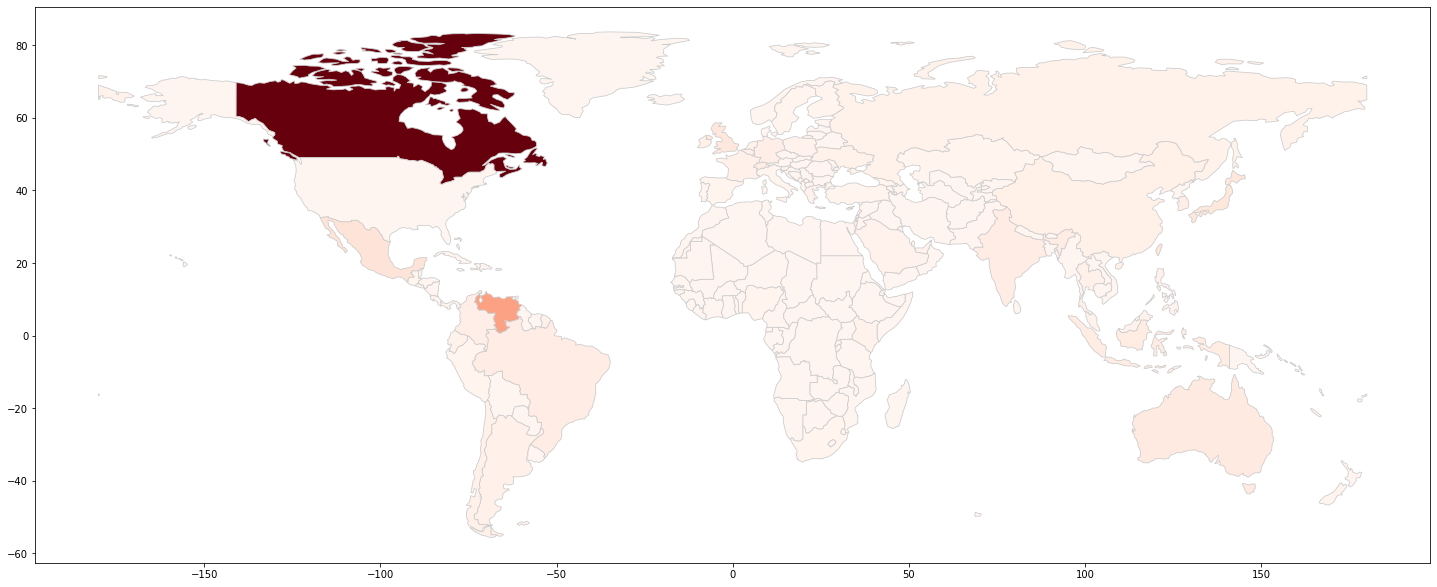

In [ ]:
geoplot = df_file[['geoNetwork.continent', 'geoNetwork.city', 'geoNetwork.metro', 'geoNetwork.subContinent', 'geoNetwork.country', 'totals.transactionRevenue']].copy()

geoplot = geoplot.groupby('geoNetwork.country')['totals.transactionRevenue'].count()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name != "Antarctica"]
merged = world.set_index('name').join(geoplot)
merged.fillna(0,inplace=True)


geo_fig = merged.plot(column='totals.transactionRevenue', cmap='Reds', 
                      figsize=(25,18),
                      linewidth=0.8, 
                      edgecolor='0.8')

geo_fig.axes.get_xaxis().set_visible(True)
geo_fig.axes.get_yaxis().set_visible(True)

In [ ]:
# Counting total visits by countrys
countMaps = pd.DataFrame(df_file['geoNetwork.country'].value_counts()).reset_index()
countMaps.columns=['country', 'counts'] #renaming columns
countMaps = countMaps.reset_index().drop('index', axis=1) #reseting index and droping the column

data = [ dict(
        type = 'choropleth',
        locations = countMaps['country'],
        locationmode = 'country names',
        z = countMaps['counts'],
        text = countMaps['country'],
        autocolorscale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of Visits'),
      ) ]

layout = dict(
    title = 'Visits Per Country',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

figure = dict( data=data, layout=layout )
iplot(figure, validate=False, filename='map-countrys-count')

In [ ]:

sumRevMaps = df_file[df_file['totals.transactionRevenue'] > 0].groupby("geoNetwork.country")["totals.transactionRevenue"].count().to_frame().reset_index()
sumRevMaps.columns = ["country", "count_sales"] # renaming columns
sumRevMaps = sumRevMaps.reset_index().drop('index', axis=1) #reseting index and drop index column

data = [ dict(
        type = 'choropleth',
        locations = sumRevMaps['country'],
        locationmode = 'country names',
        z = sumRevMaps['count_sales'],
        text = sumRevMaps['country'],
        autocolorscale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = True,
            tickprefix = '',
            title = 'Count of Sales'),
      ) ]

layout = dict(
    title = 'Total Sales by Country',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

figure = dict( data=data, layout=layout )

iplot(figure, validate=False, filename='map-countrys-total')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [ ]:
df['totals.pageviews'].mode()

0    1
dtype: object

In [ ]:
columns_to_remove = [col for col in df.columns if df[col].nunique() == 1]
print("No. of variables with unique value: {}".format(len(columns_to_remove)))

No. of variables with unique value: 24


In [ ]:
columns_to_remove

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']

In [ ]:
for col in columns_to_remove:
    if set(['not available in demo dataset']) ==  set(df[col].unique()): continue
    print(col, df[col].dtypes, df[col].unique())

socialEngagementType object ['Not Socially Engaged']
totals.visits object ['1']
totals.bounces object ['1' nan]
totals.newVisits object ['1' nan]
trafficSource.isTrueDirect object [nan True]
trafficSource.adwordsClickInfo.isVideoAd object [nan False]
trafficSource.campaignCode object [nan '11251kjhkvahf']


In [ ]:
df_1 = df.copy()

In [ ]:
df_1.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [ ]:
df_1['totals.pageviews'].fillna(1, inplace=True) # mode of page views is 1
df_1['totals.newVisits'].fillna(0, inplace=True)
df_1['totals.bounces'].fillna(0, inplace=True) 
df_1["totals.transactionRevenue"].fillna(0.0, inplace=True)

#Changing objects to int
df_1['totals.pageviews'] = df_1['totals.pageviews'].astype(int)
df_1['totals.newVisits'] = df_1['totals.newVisits'].astype(int)
df_1['totals.bounces'] = df_1['totals.bounces'].astype(int)
df_1["totals.transactionRevenue"] = df_1["totals.transactionRevenue"].astype(float)

df_1['trafficSource.isTrueDirect'].fillna(False, inplace=True) 
df_1['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean with True

In [ ]:
df_1.isnull().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserVersion                                     0
device.browserSize                                        0
device.operatingSystem                                    0
device.operatingSystemVersion                             0
device.isMobile                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceModel                                  0
device.mobileInputSelector              

In [ ]:
columns = [col for col in df_1.columns if df_1[col].nunique() > 1]
df_1 = df_1[columns]

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 35 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               903653 non-null  object 
 1   date                                          903653 non-null  int64  
 2   fullVisitorId                                 903653 non-null  object 
 3   sessionId                                     903653 non-null  object 
 4   visitId                                       903653 non-null  int64  
 5   visitNumber                                   903653 non-null  int64  
 6   visitStartTime                                903653 non-null  int64  
 7   device.browser                                903653 non-null  object 
 8   device.operatingSystem                        903653 non-null  object 
 9   device.isMobile                               90

In [ ]:
df_1.isnull().sum()

channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
sessionId                                            0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device.browser                                       0
device.operatingSystem                               0
device.isMobile                                      0
device.deviceCategory                                0
geoNetwork.continent                                 0
geoNetwork.subContinent                              0
geoNetwork.country                                   0
geoNetwork.region                                    0
geoNetwork.metro                                     0
geoNetwork.city                                      0
geoNetwork.networkDomain                             0
totals.hit

In [ ]:
# Removing columns with high null values 
df_1.drop(columns=['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId',
                'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', 'trafficSource.referralPath',
                 'trafficSource.keyword'], inplace = True)

In [ ]:
# for col in df_1.columns:
#     if len(df_1[col].unique()) == 1:
#         df_1.drop(col,inplace=True,axis=1)

In [ ]:
print(df.shape)
print(df_1.shape)

(903653, 55)
(903653, 28)


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 28 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   channelGrouping                           903653 non-null  object 
 1   date                                      903653 non-null  int64  
 2   fullVisitorId                             903653 non-null  object 
 3   sessionId                                 903653 non-null  object 
 4   visitId                                   903653 non-null  int64  
 5   visitNumber                               903653 non-null  int64  
 6   visitStartTime                            903653 non-null  int64  
 7   device.browser                            903653 non-null  object 
 8   device.operatingSystem                    903653 non-null  object 
 9   device.isMobile                           903653 non-null  bool   
 10  device.deviceCategor

In [ ]:
# Converting to float
# df_1['fullVisitorId'] = df_1['fullVisitorId'].astype(float)
# df_1['sessionId'] = df_1['sessionId'].astype(float)

In [ ]:
# df_1["date"] = pd.to_datetime(df_1["date"], format="%Y%m%d") # seting the column as pandas datetime
# df_1["weekday"] = df_1['date'].dt.weekday #extracting week day
# df_1["day"] = df_1['date'].dt.day # extracting day
# df_1["month"] = df_1['date'].dt.month # extracting day
# df_1["year"] = df_1['date'].dt.year # extracting day


In [ ]:
df_1.shape

(903653, 28)

In [ ]:
# Copy into another dataframe to complete feature Engineering

In [ ]:
df_2 = df_1.copy()

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 28 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   channelGrouping                           903653 non-null  object 
 1   date                                      903653 non-null  int64  
 2   fullVisitorId                             903653 non-null  object 
 3   sessionId                                 903653 non-null  object 
 4   visitId                                   903653 non-null  int64  
 5   visitNumber                               903653 non-null  int64  
 6   visitStartTime                            903653 non-null  int64  
 7   device.browser                            903653 non-null  object 
 8   device.operatingSystem                    903653 non-null  object 
 9   device.isMobile                           903653 non-null  bool   
 10  device.deviceCategor

In [ ]:
# Visit time
df_2['diff_visitId_time'] = df_2['visitId'] - df_2['visitStartTime']
df_2['diff_visitId_time'] = (df_2['diff_visitId_time'] != 0).astype(int)
del df_2['visitId']

In [ ]:
import time
# Visit hour
df_2['formated_visitStartTime'] = df_2['visitStartTime'].apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
df_2['formated_visitStartTime'] = pd.to_datetime(df_2['formated_visitStartTime'])
df_2['visit_hour'] = df_2['formated_visitStartTime'].apply(lambda x: x.hour)
 
del df_2['visitStartTime']
del df_2['formated_visitStartTime']

In [ ]:
# date
from datetime import datetime
format_str = '%Y%m%d' 
df_2['formated_date'] = df_2['date'].apply(lambda x: datetime.strptime(str(x), format_str))
df_2['month'] = df_2['formated_date'].apply(lambda x:x.month)
df_2['quarter_month'] = df_2['formated_date'].apply(lambda x:x.day//8)
df_2['day'] = df_2['formated_date'].apply(lambda x:x.day)
df_2['weekday'] = df_2['formated_date'].apply(lambda x:x.weekday())
 
del df_2['date']

In [ ]:
# total hits
df_2['totals.hits'] = df_2['totals.hits'].astype(int)
df_2['mean_hits_per_day'] = df_2.groupby(['day'])['totals.hits'].transform('mean')
del  df_2['day']

In [ ]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    df_2[col] = df_2[col].astype(float)

In [ ]:
# Removing unwanted id columns
df_2 = df_2.drop(['fullVisitorId','sessionId'], axis = 1)

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   channelGrouping                           903653 non-null  object        
 1   visitNumber                               903653 non-null  float64       
 2   device.browser                            903653 non-null  object        
 3   device.operatingSystem                    903653 non-null  object        
 4   device.isMobile                           903653 non-null  bool          
 5   device.deviceCategory                     903653 non-null  object        
 6   geoNetwork.continent                      903653 non-null  object        
 7   geoNetwork.subContinent                   903653 non-null  object        
 8   geoNetwork.country                        903653 non-null  object        
 9   geoNetwork.regi

In [ ]:
df_2.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,visit_hour,formated_date,month,quarter_month,weekday,mean_hits_per_day
0,Organic Search,1.0,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1.0,1.0,1.0,1.0,0.0,(not set),google,organic,False,True,0,15,2016-09-02,9,0,4,4.638119
1,Organic Search,1.0,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1.0,1.0,1.0,1.0,0.0,(not set),google,organic,False,True,0,5,2016-09-02,9,0,4,4.638119
2,Organic Search,1.0,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1.0,1.0,1.0,1.0,0.0,(not set),google,organic,False,True,0,1,2016-09-02,9,0,4,4.638119
3,Organic Search,1.0,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1.0,1.0,1.0,1.0,0.0,(not set),google,organic,False,True,0,5,2016-09-02,9,0,4,4.638119
4,Organic Search,2.0,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1.0,1.0,1.0,0.0,0.0,(not set),google,organic,True,True,0,13,2016-09-02,9,0,4,4.638119


In [ ]:
# Copy for Encoding categorical features
df_3 = df_2.copy()

In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   channelGrouping                           903653 non-null  object        
 1   visitNumber                               903653 non-null  float64       
 2   device.browser                            903653 non-null  object        
 3   device.operatingSystem                    903653 non-null  object        
 4   device.isMobile                           903653 non-null  bool          
 5   device.deviceCategory                     903653 non-null  object        
 6   geoNetwork.continent                      903653 non-null  object        
 7   geoNetwork.subContinent                   903653 non-null  object        
 8   geoNetwork.country                        903653 non-null  object        
 9   geoNetwork.regi

In [ ]:
cat_cols = ["channelGrouping", "device.browser", 
             "device.operatingSystem", 'device.isMobile','device.deviceCategory',
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", 
             "trafficSource.campaign",
            "trafficSource.medium", 
             "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

In [ ]:
# Label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
    # print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df_3[col].values.astype('str')))
    df_3[col] = lbl.transform(list(df_3[col].values.astype('str')))

In [ ]:
# Converting to numerical columns


In [ ]:
num_cols = ["totals.hits", "totals.pageviews", 
            "visitNumber", 
            'totals.bounces',  'totals.newVisits']    

for col in num_cols:
    df_3[col] = df_3[col].astype(float)

In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   channelGrouping                           903653 non-null  int64         
 1   visitNumber                               903653 non-null  float64       
 2   device.browser                            903653 non-null  int64         
 3   device.operatingSystem                    903653 non-null  int64         
 4   device.isMobile                           903653 non-null  int64         
 5   device.deviceCategory                     903653 non-null  int64         
 6   geoNetwork.continent                      903653 non-null  int64         
 7   geoNetwork.subContinent                   903653 non-null  int64         
 8   geoNetwork.country                        903653 non-null  int64         
 9   geoNetwork.regi

In [ ]:
df_3.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,visit_hour,formated_date,month,quarter_month,weekday,mean_hits_per_day
0,4,1.0,11,16,0,0,3,21,204,150,0,258,24932,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,15,2016-09-02,9,0,4,4.638119
1,4,1.0,16,7,0,0,5,1,12,375,93,648,6673,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,5,2016-09-02,9,0,4,4.638119
2,4,1.0,11,16,0,0,4,19,181,78,0,325,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,1,2016-09-02,9,0,4,4.638119
3,4,1.0,46,6,0,0,3,16,94,375,93,648,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,5,2016-09-02,9,0,4,4.638119
4,4,2.0,11,1,1,1,4,13,211,375,93,648,25841,1.0,1.0,1.0,0.0,0.0,0,149,5,1,1,0,13,2016-09-02,9,0,4,4.638119


In [ ]:
df_3['visit_hour_sin'] = np.sin(df_3.visit_hour*(2.*np.pi/24))
df_3['visit_hour_cos'] = np.cos(df_3.visit_hour*(2.*np.pi/24))
df_3['month_sin'] = np.sin((df_3.month-1)*(2.*np.pi/12))
df_3['month_cos'] = np.cos((df_3.month-1)*(2.*np.pi/12))

In [ ]:
df_3['weekday_sin'] = np.sin((df_3.weekday-1)*(2.*np.pi/7))
df_3['weekday_cos'] = np.cos((df_3.weekday-1)*(2.*np.pi/7))


In [ ]:
del df_3['month']
del df_3['visit_hour']

In [ ]:
del df_3['weekday']

In [ ]:
df_3.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,formated_date,quarter_month,mean_hits_per_day,visit_hour_sin,visit_hour_cos,month_sin,month_cos,weekday_sin,weekday_cos
0,4,1.0,11,16,0,0,3,21,204,150,0,258,24932,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,2016-09-02,0,4.638119,-0.707107,-0.707107,-0.866025,-0.5,0.433884,-0.900969
1,4,1.0,16,7,0,0,5,1,12,375,93,648,6673,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,2016-09-02,0,4.638119,0.965926,0.258819,-0.866025,-0.5,0.433884,-0.900969
2,4,1.0,11,16,0,0,4,19,181,78,0,325,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,2016-09-02,0,4.638119,0.258819,0.965926,-0.866025,-0.5,0.433884,-0.900969
3,4,1.0,46,6,0,0,3,16,94,375,93,648,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,2016-09-02,0,4.638119,0.965926,0.258819,-0.866025,-0.5,0.433884,-0.900969
4,4,2.0,11,1,1,1,4,13,211,375,93,648,25841,1.0,1.0,1.0,0.0,0.0,0,149,5,1,1,0,2016-09-02,0,4.638119,-0.258819,-0.965926,-0.866025,-0.5,0.433884,-0.900969


In [ ]:
# cat_cols_1 = ['quarter_month','month','weekday','visit_hour']

In [ ]:
# for col in cat_cols_1:
#     # print(col)
#     lbl = preprocessing.LabelEncoder()
#     lbl.fit(list(df_2[col].values.astype('str')))
#     df_2[col] = lbl.transform(list(df_2[col].values.astype('str')))

In [ ]:
# df_2.info()

In [ ]:
plt.rcParams["figure.figsize"] = (30,30)

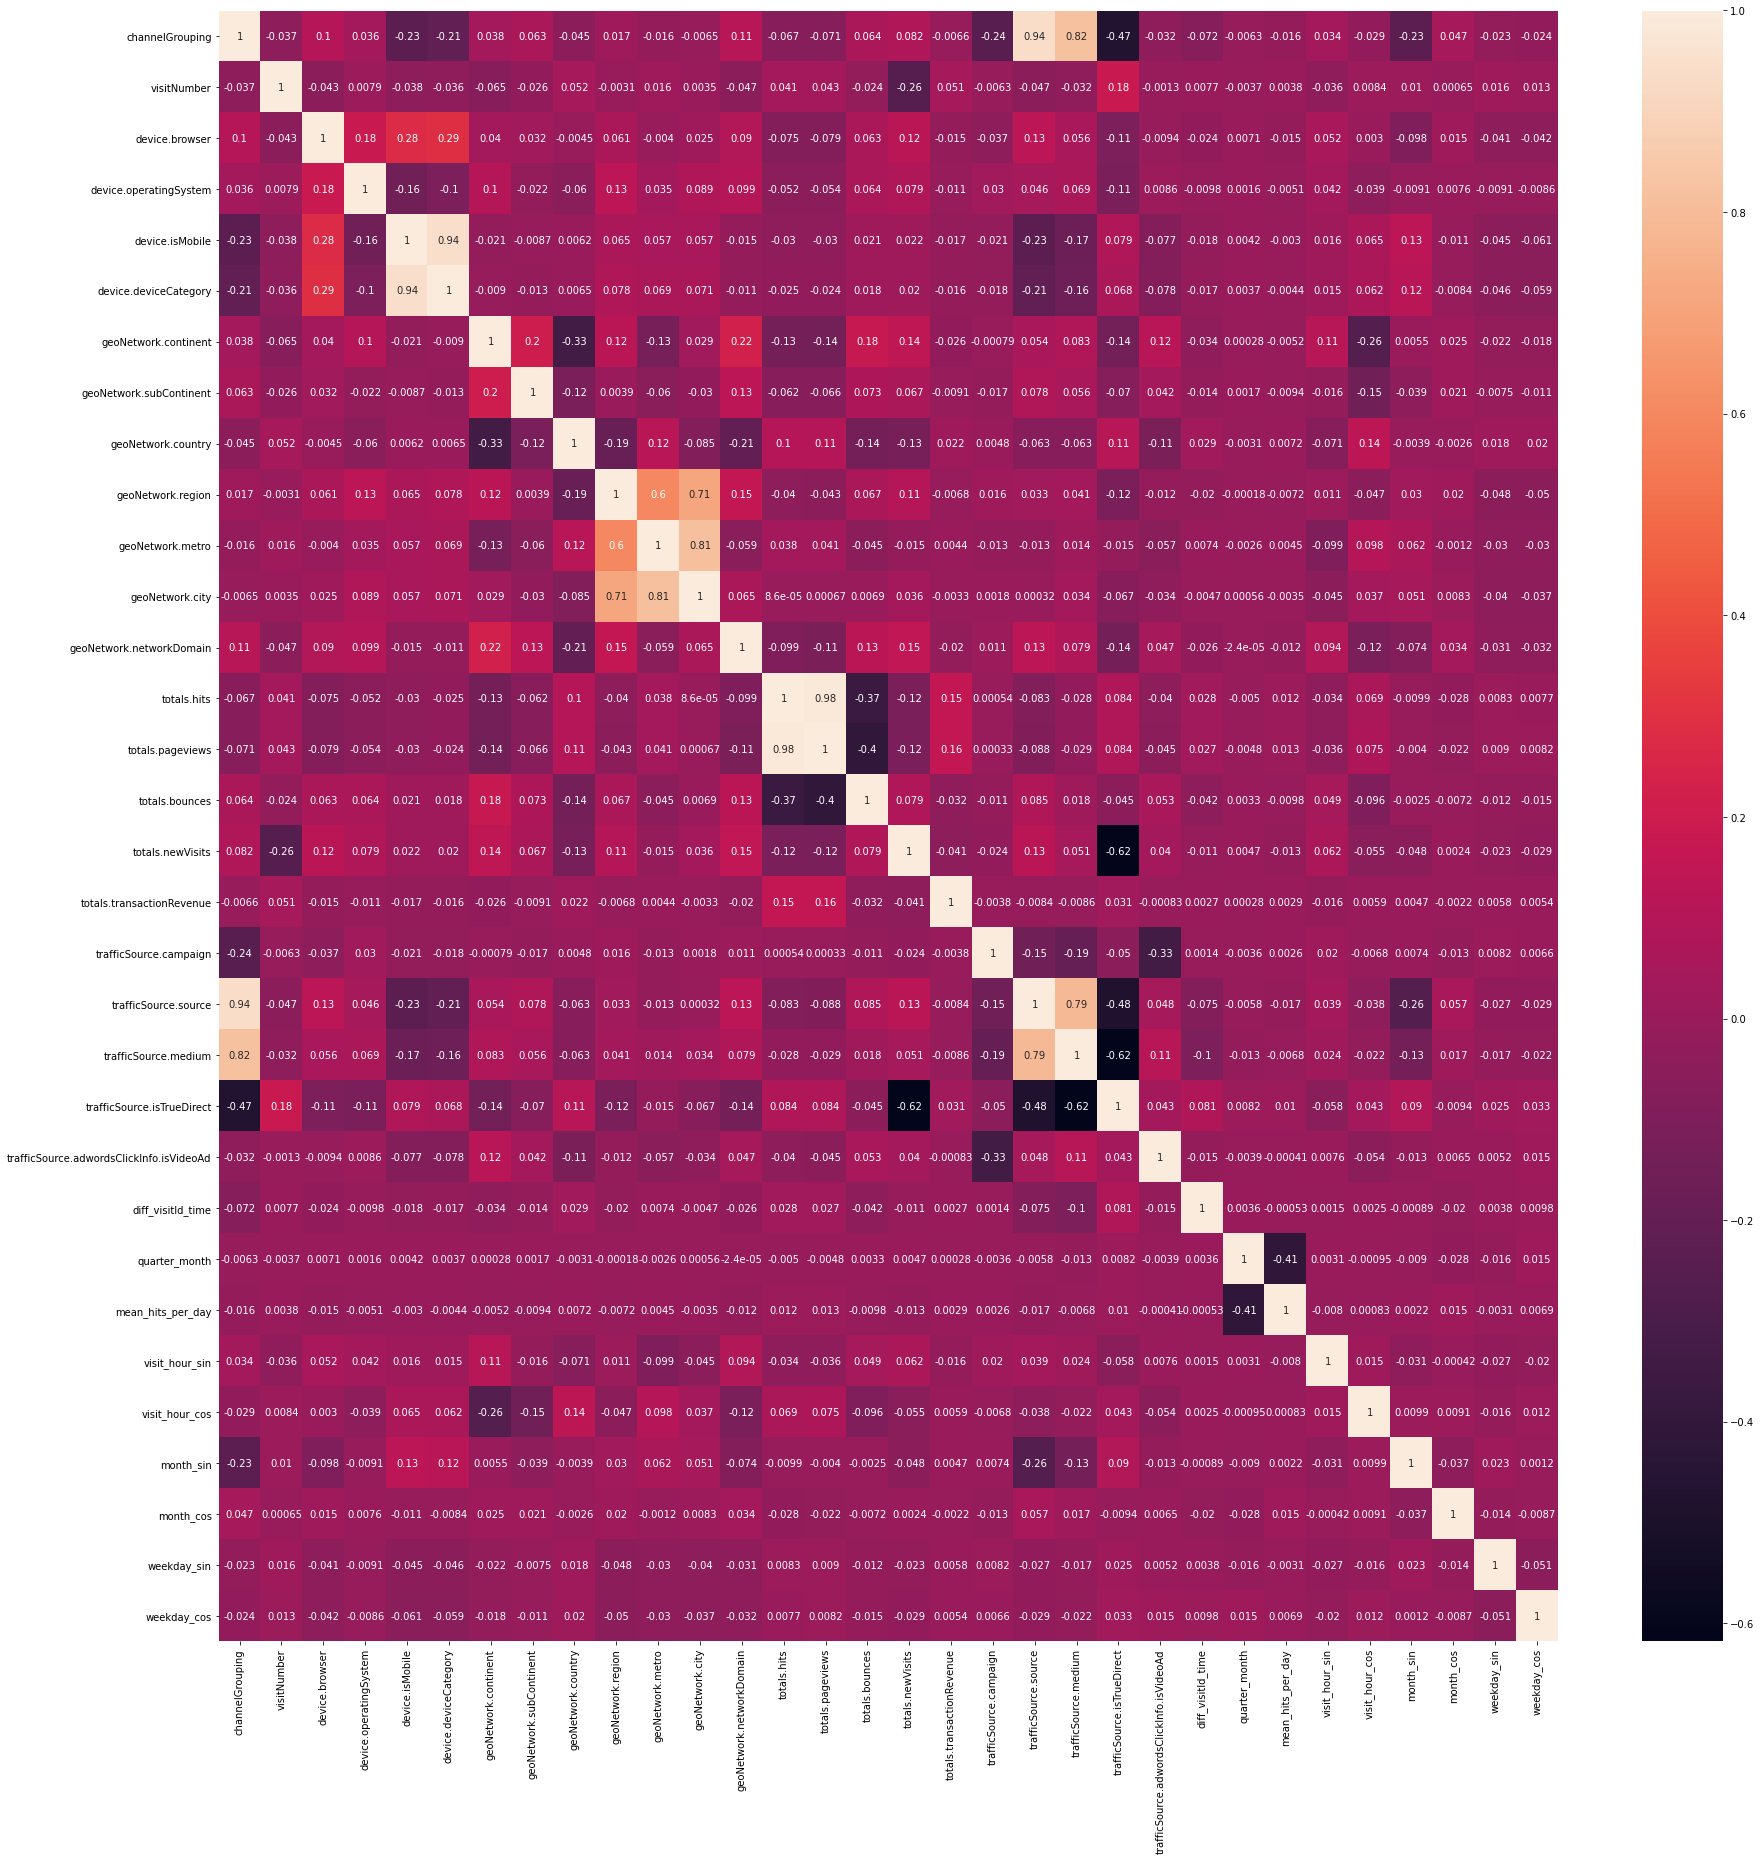

In [ ]:
sns.heatmap(df_3.corr(), annot = True)

In [ ]:
# Feature Engineering completed

In [ ]:
# Dividing into training and testing

In [ ]:
X = df_3.copy()

In [ ]:
X.shape

(903653, 33)

In [ ]:
X.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,formated_date,quarter_month,mean_hits_per_day,visit_hour_sin,visit_hour_cos,month_sin,month_cos,weekday_sin,weekday_cos
0,4,1.0,11,16,0,0,3,21,204,150,0,258,24932,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,2016-09-02,0,4.638119,-0.707107,-0.707107,-0.866025,-0.5,0.433884,-0.900969
1,4,1.0,16,7,0,0,5,1,12,375,93,648,6673,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,2016-09-02,0,4.638119,0.965926,0.258819,-0.866025,-0.5,0.433884,-0.900969
2,4,1.0,11,16,0,0,4,19,181,78,0,325,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,2016-09-02,0,4.638119,0.258819,0.965926,-0.866025,-0.5,0.433884,-0.900969
3,4,1.0,46,6,0,0,3,16,94,375,93,648,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,2016-09-02,0,4.638119,0.965926,0.258819,-0.866025,-0.5,0.433884,-0.900969
4,4,2.0,11,1,1,1,4,13,211,375,93,648,25841,1.0,1.0,1.0,0.0,0.0,0,149,5,1,1,0,2016-09-02,0,4.638119,-0.258819,-0.965926,-0.866025,-0.5,0.433884,-0.900969


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 33 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   channelGrouping                           903653 non-null  int64         
 1   visitNumber                               903653 non-null  float64       
 2   device.browser                            903653 non-null  int64         
 3   device.operatingSystem                    903653 non-null  int64         
 4   device.isMobile                           903653 non-null  int64         
 5   device.deviceCategory                     903653 non-null  int64         
 6   geoNetwork.continent                      903653 non-null  int64         
 7   geoNetwork.subContinent                   903653 non-null  int64         
 8   geoNetwork.country                        903653 non-null  int64         
 9   geoNetwork.regi

In [ ]:
# X_new = X.drop('date', axis = 1)

In [ ]:
from datetime import datetime, date

In [ ]:
X = X.set_index(X['formated_date'])
X = X.sort_index()

In [ ]:
min(X['formated_date'])

Timestamp('2016-08-01 00:00:00')

In [ ]:
max(X['formated_date'])

Timestamp('2017-08-01 00:00:00')

In [ ]:
train = X['2016-08-01':'2017-05-31']
test  = X['2017-05-31':]


In [ ]:
print(train.shape)
print(test.shape)

(765707, 33)
(140238, 33)


In [ ]:
# Dropping date and target column
X_train = train.drop(['formated_date','totals.transactionRevenue'], axis = 1)
X_test = test.drop(['formated_date','totals.transactionRevenue'], axis=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(765707, 31)
(140238, 31)


In [ ]:
X_train.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,quarter_month,mean_hits_per_day,visit_hour_sin,visit_hour_cos,month_sin,month_cos,weekday_sin,weekday_cos
formated_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01,2,1.0,11,7,0,0,3,6,102,375,93,648,10955,1.0,1.0,1.0,1.0,0,0,0,1,1,0,0,4.612934,0.707107,-0.707107,-0.5,-0.866025,-0.781831,0.62349
2016-08-01,2,3.0,11,16,0,0,3,16,217,129,0,235,25841,1.0,1.0,1.0,0.0,0,0,0,1,1,0,0,4.612934,0.707107,-0.707107,-0.5,-0.866025,-0.781831,0.62349
2016-08-01,6,1.0,11,7,0,0,2,12,212,57,78,366,0,1.0,1.0,1.0,1.0,0,267,6,0,1,0,0,4.612934,-0.258819,0.965926,-0.5,-0.866025,-0.781831,0.62349
2016-08-01,2,1.0,11,16,0,0,2,15,28,375,93,648,3305,1.0,1.0,1.0,1.0,0,0,0,1,1,0,0,4.612934,-0.965926,0.258819,-0.5,-0.866025,-0.781831,0.62349
2016-08-01,2,1.0,40,7,0,0,3,16,199,375,93,648,25841,1.0,1.0,1.0,1.0,0,0,0,1,1,0,0,4.612934,0.866025,0.500000,-0.5,-0.866025,-0.781831,0.62349


In [ ]:
out = test['totals.transactionRevenue'].values

In [ ]:
output = pd.DataFrame(out)

In [ ]:
output.columns = ['ActualRevenue']

In [ ]:
output.head()

,ActualRevenue
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
#  transaction revenue
y_train = np.log1p(train["totals.transactionRevenue"].values)
y_test = np.log1p(test["totals.transactionRevenue"].values)

In [ ]:
print(y_train.shape)
print(y_test.shape)

(765707,)
(140238,)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print(' Root Mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))

Coefficients: 
 [ 4.27754337e-02 -3.32297018e-03  3.84471875e-04 -5.34877482e-03
 -1.33505111e-01 -1.19096168e-02 -4.06123355e-02 -5.43856910e-05
  8.12563615e-04  1.51362189e-04  1.91254681e-04 -1.46844741e-04
 -1.93246339e-06 -1.07858955e-01  2.61143680e-01  3.13435315e-01
 -1.94379274e-01  1.29394823e-02  2.22964349e-04 -6.08209931e-03
  1.54883262e-01  1.76747711e-01 -1.01571854e-01  4.93990065e-03
  5.17033493e-02 -5.50020611e-02 -8.32575664e-04  5.24618959e-02
  1.45231465e-02  2.49193950e-03  4.33326598e-03]
Mean squared error: 3.70
 Root Mean squared error: 1.92
Coefficient of determination: 0.19


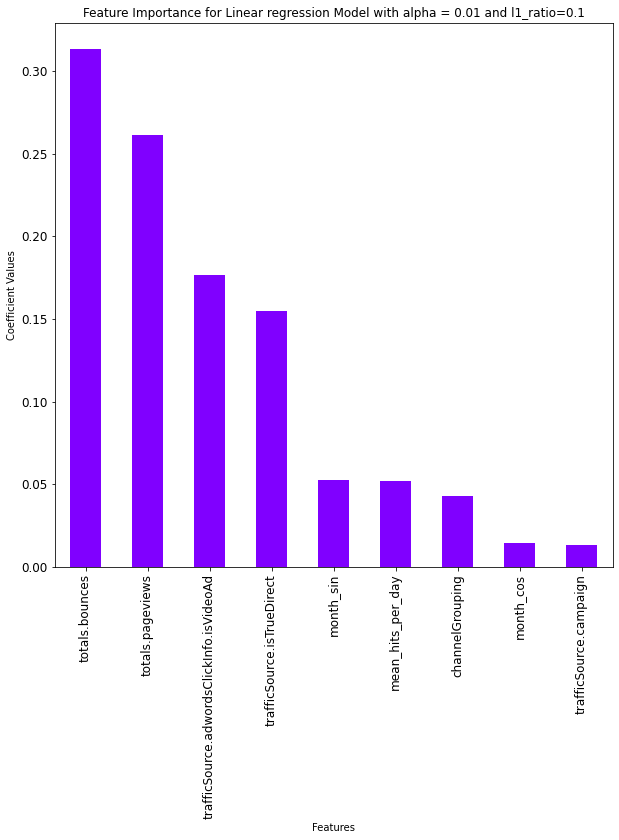

In [ ]:
Coloumn_Coeff= [(X_train.columns[i], regr.coef_ [i]) for i in range(len(regr.coef_))]
Coloumn_Coeff=sorted(Coloumn_Coeff, key=lambda x:  (x[1]),reverse=True)
Coloumn_Coeff
column = []
val = []
for v in Coloumn_Coeff:
  if v[1] > 0.01:
    column.append(v[0])
    val.append(v[1])
val
column
importance = pd.Series(index = column, data = val)
importance.plot(kind='bar', title = "Feature Importance for Linear regression Model with alpha = 0.01 and l1_ratio=0.1", xlabel= "Features", ylabel="Coefficient Values", colormap="rainbow", figsize = (10,10),fontsize=12)
